# Assignment 8

This assignement will be covered with two tutorium, you don't have to give back any work before holidays. The next part will be uploaded during the holidays and after the next tutorium after holidays, you will have to give back your work. 



## Ex. 8.0
We start by installing pytorch, a popular machine learning framework. Go to [pytorch.org](https://pytorch.org/), choose your target system and install pytorch (via conda).

You can try pytorch on [Google Colab](https://colab.research.google.com), too. Colab integrates with your Google account, your notebooks will be stored on Google Drive and you can read datasets from there too. You can even use GPUs and TPUs! However, we still suggest you install pytorch on your local computer because variables might get lost when your computer disconnects from the internet or the notebook runs idle for a while.  

Browse through the [pytorch tutorials ](https://pytorch.org/tutorials/), they often come as colab notebooks - go and execute some!

In [0]:
import sys
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

## Ex. 8.1
Make your own convolutionnal network of the following structure : 3 layer of convolution and 2 layer of neurones. We would like to see in it some padding, stride, pooling, drop out and batch normalization. Use the ReLU activation fonction. You should define your network, make a train fonction, a test fonction to display the result and make them work!

Setup some hyper-parameter for your network

In [2]:
n_epochs = 3
batch_size_train = 10
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Now, load MNIST from torch and 

In [3]:
train = torchvision.datasets.MNIST('./data', train=True, download=True,
                                   transform=transforms.Compose([
                                                                 transforms.ToTensor()
                                                                 ]))
test = torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor()]))

train_data = (train.data.float() / 255.).reshape([-1, 1, 28, 28])
train_targets = train.targets
test_data = (test.data.float() / 255.).reshape([-1, 1, 28, 28])
test_targets = test.targets

0it [00:00, ?it/s]

9920512it [00:01, 9587163.91it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142833.64it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2239557.74it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 52145.93it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
test_loader = DataLoader(TensorDataset(train_data, train_targets), batch_size=10, shuffle=False)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([10, 1, 28, 28])

Display some instance of the training set

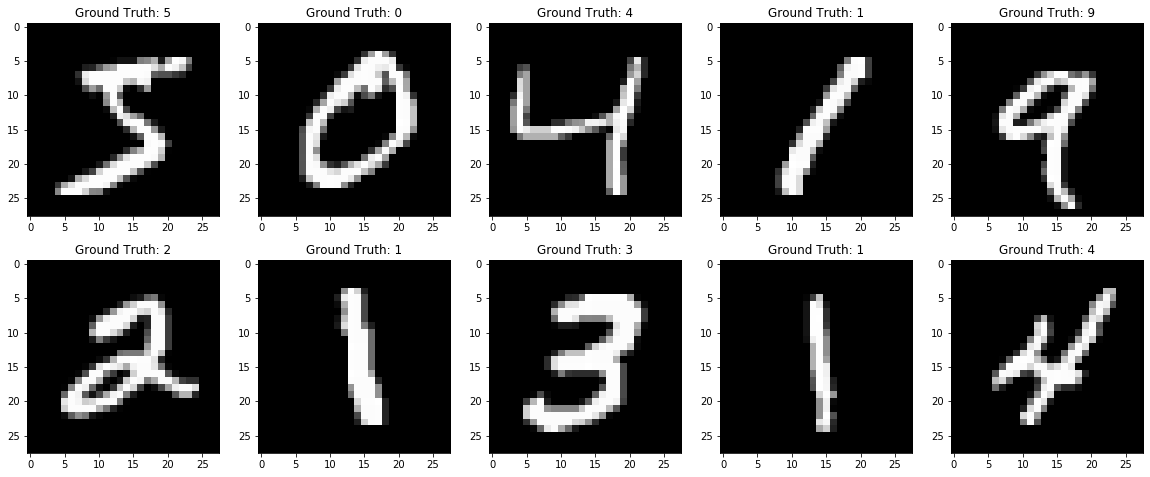

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i, axis in enumerate(ax.reshape(-1)):
  axis.imshow(example_data[i][0], cmap='gray', interpolation='none')
  axis.set_title("Ground Truth: {}".format(example_targets[i]))
plt.show()

First of all, we define our model class `CNN` which extends from `torch.nn.Module`.

In [0]:
class CNN(torch.nn.Module):
  def __init__(self, D_out):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    
    self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(128)

    self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(256)

    self.drop1 = nn.Dropout(p=0.2)
    self.dense1 = nn.Linear(256*4*4, 512)
    
    self.drop2 = nn.Dropout(p=0.2)
    self.dense2 = nn.Linear(512, D_out)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x))
    x = self.bn1(x)
    x = F.leaky_relu(self.conv2(x))
    x = self.bn2(x)
    x = F.leaky_relu(self.conv3(x))
    x = self.bn3(x)

    #Flatten output and feet to linear layers
    N, c, w, h = x.shape
    x = x.reshape([N, w*h*c])

    x = F.leaky_relu(self.dense1(self.drop1(x)))
    y = F.leaky_relu(self.dense2(self.drop2(x)))
    return y
  
  def runtrain(self, x, y, val_x=None, val_y=None, lr=1e-2, momentum=0.9, max_epochs=1000, batch_size=100):
    self.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
    should_validate = False
    if not(val_x is None) and not(val_y is None):
        assert len(val_x) == len(val_y)
        should_validate = True
        
    training = TensorDataset(x, y)
    if should_validate:
      test = TensorDataset(val_x, val_y)

    losses = []
    step = 0
    for t in range(max_epochs):
        sum_loss = 0
        batch_count = 0
        loader = DataLoader(training, batch_size=batch_size, shuffle=True)
        for x_, y_ in loader:
            x_ = x_.cuda()
            y_ = y_.cuda()
            y_pred = self.forward(x_)
            accuracy = (torch.argmax(y_pred, dim=1) == y_).sum().item() / len(y_)
            
            if should_validate:
              loader_test = iter(DataLoader(test, batch_size=batch_size, shuffle=True))
              x_test, y_test = next(loader_test)
              x_test = x_test.cuda()
              y_test = y_test.cuda()
              y_pred_test = self.forward(x_test)
              accuracy_test = (torch.argmax(y_pred_test, dim=1) == y_test).sum().item() / len(y_test)

            loss = criterion(y_pred, y_)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss
            batch_count += 1
            avg_loss = sum_loss / batch_count
            step += 1
            
            if should_validate:
                sys.stdout.write("\rEpoch: {}, Step: {}, Loss: {:.10f}, Accuracy: {:.2%}, Validation accuracy: {:.2%}".format(t+1, step, avg_loss, accuracy, accuracy_test))
            else:
                sys.stdout.write("\rEpoch: {}, Step: {}, Loss: {:.10f}, Accuracy: {:.2%}".format(t+1, step, avg_loss, accuracy))

        avg_loss = avg_loss / batch_count
        losses.append(avg_loss.item())

    return losses


In [33]:
model = CNN(10)
model.cuda()
losses = model.runtrain(train_data, train_targets, val_x=test_data, val_y=test_targets, lr=1e-3, max_epochs=10)

Epoch: 10, Step: 6000, Loss: 0.0176403765, Accuracy: 98.00%, Validation accuracy: 99.00%

Finally, we write a `test()` function that takes in two tensors `x`, `y`, computes the label predicted by the model for `x`, plots the number and compares the expected and the predicted label.

In [0]:
def test(model, x, y):
  assert len(x) == len(y)
  model.eval()
  # Transfer tensor to GPU
  x_ = x.cuda()
  y_ = model(x_)
  # Detach output from computational graph and transfer back to CPU
  y_ = np.argmax(y_.detach().cpu().numpy(), axis=1)
  n = math.ceil(len(x) // 5)
  fig, ax = plt.subplots(n, 5, figsize=(20, 4 * n))
  for i, axis in enumerate(ax.reshape(-1)):
    axis.imshow(x[i].reshape([28, 28]), cmap='gray')
    axis.set_title("Target: {} Prediction: {}".format(y[i], y_[i]))
  plt.plot()

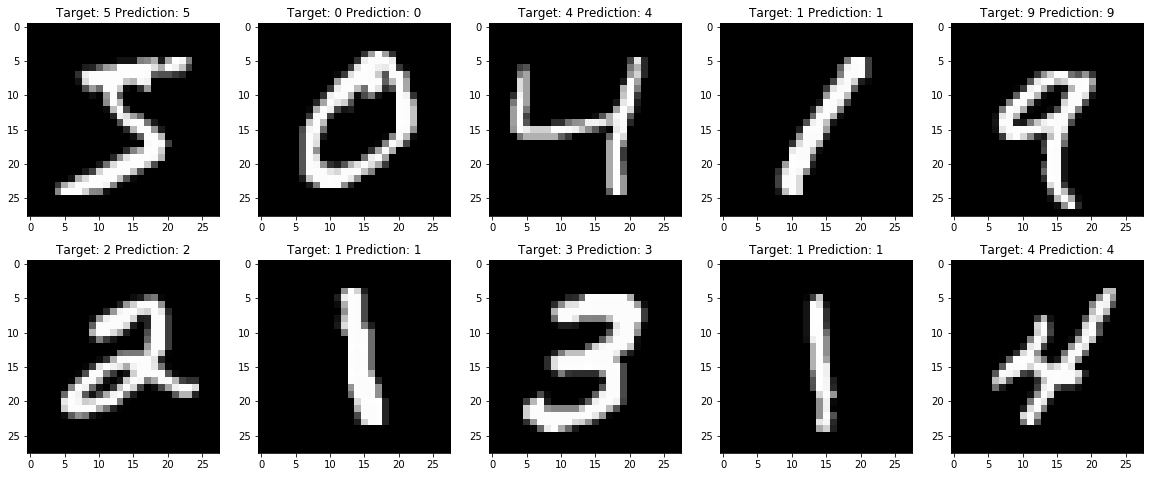

In [35]:
batch_x, batch_y = next(iter(test_loader))
batch_x.shape, batch_y.shape
test(model, batch_x, batch_y)

As we can see, the outputs all match the respective labels.